<a href="https://colab.research.google.com/github/ParthDave111/Quant-and-Finance-File/blob/main/Bates_1996_Asian_Put.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.interpolate import splev, splrep
from scipy.optimize import brute, fmin

In [ ]:
import pandas as pd


df = pd.read_excel('/content/MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx')


print(df.head())

   Days to maturity  Strike  Price Type
0                15   227.5  10.52    C
1                15   230.0  10.05    C
2                15   232.5   7.75    C
3                15   235.0   6.01    C
4                15   237.5   4.75    C


In [ ]:
df['r'] = 0.015

In [ ]:
S0 = 232.90

In [ ]:
df

,Days to maturity,Strike,Price,Type,r
0,15,227.5,10.520000,C,0.015
1,15,230.0,10.050000,C,0.015
2,15,232.5,7.750000,C,0.015
3,15,235.0,6.010000,C,0.015
4,15,237.5,4.750000,C,0.015
5,60,227.5,16.780000,C,0.015
6,60,230.0,17.650000,C,0.015
7,60,232.5,16.860000,C,0.015
8,60,235.0,16.050000,C,0.015
9,60,237.5,15.100000,C,0.015


In [ ]:
df_filtered = df[(df['Days to maturity'] == 60)]
print(df_filtered)

    Days to maturity  Strike  Price Type      r
5                 60   227.5  16.78    C  0.015
6                 60   230.0  17.65    C  0.015
7                 60   232.5  16.86    C  0.015
8                 60   235.0  16.05    C  0.015
9                 60   237.5  15.10    C  0.015
20                60   227.5  11.03    P  0.015
21                60   230.0  12.15    P  0.015
22                60   232.5  13.37    P  0.015
23                60   235.0  14.75    P  0.015
24                60   237.5  15.62    P  0.015


In [ ]:
df = df_filtered

In [ ]:
df

,Days to maturity,Strike,Price,Type,r
5,60,227.5,16.78,C,0.015
6,60,230.0,17.65,C,0.015
7,60,232.5,16.86,C,0.015
8,60,235.0,16.05,C,0.015
9,60,237.5,15.10,C,0.015
20,60,227.5,11.03,P,0.015
21,60,230.0,12.15,P,0.015
22,60,232.5,13.37,P,0.015
23,60,235.0,14.75,P,0.015
24,60,237.5,15.62,P,0.015


we will calibtate call first and then put

In [ ]:
df_filtered = df[df['Type'] == 'P']
print(df_filtered)

    Days to maturity  Strike  Price Type      r
20                60   227.5  11.03    P  0.015
21                60   230.0  12.15    P  0.015
22                60   232.5  13.37    P  0.015
23                60   235.0  14.75    P  0.015
24                60   237.5  15.62    P  0.015


In [ ]:
df = df_filtered

In [ ]:
  T = (df["Days to maturity"]) / 365

In [ ]:
df['T'] = df['Days to maturity'] / 365

<ipython-input-13-5150a1693dcb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['T'] = df['Days to maturity'] / 365


In [ ]:
df

,Days to maturity,Strike,Price,Type,r,T
20,60,227.5,11.03,P,0.015,0.164384
21,60,230.0,12.15,P,0.015,0.164384
22,60,232.5,13.37,P,0.015,0.164384
23,60,235.0,14.75,P,0.015,0.164384
24,60,237.5,15.62,P,0.015,0.164384


Fing avg_s

In [ ]:
!pip install numpy scipy

import numpy as np
from scipy.stats import norm

def asian_option_average_price(S0, T, r, sigma, n_simulations, n_steps):
    """
    Calculates the average underlying asset price for an Asian option
    using Monte Carlo simulation.

    Parameters:
    S0 : float
        Initial stock price.
    T : float
        Time to maturity (in years).
    r : float
        Risk-free interest rate.
    sigma : float
        Volatility.
    n_simulations : int
        Number of simulations.
    n_steps : int
        Number of time steps.

    Returns:
    float
        Estimated average price of the underlying asset.
    """

    dt = T / n_steps
    average_prices = []

    for _ in range(n_simulations):
        # Generate stock price path
        prices = [S0]
        for _ in range(n_steps):
            z = norm.rvs()  # Standard normal random variable
            prices.append(prices[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z))

        # Calculate average price
        avg_price = np.mean(prices[1:])  # Exclude initial price
        average_prices.append(avg_price)

    # Calculate overall average price
    overall_average_price = np.mean(average_prices)

    return overall_average_price

In [ ]:
S0 = 232.90      # Initial stock price
T = 0.164384        # Time to maturity (60 days)
r = 0.015      # Risk-free interest rate
sigma = 0.2   # Volatility
n_simulations = 10000  # Number of simulations
n_steps = 252         # Number of time steps (daily)

average_price = asian_option_average_price(S0, T, r, sigma, n_simulations, n_steps)

print(f"Estimated Average Underlying Asset Price: {average_price:.4f}")


Estimated Average Underlying Asset Price: 233.4167


In [ ]:
avg_s = 233.41

In [ ]:
i = 0
min_MSE = 500

In [ ]:
def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0

    se = []
    for index, row in df.iterrows():
        model_value = H93_put_value(
            S0,
            row["Strike"],
            row["Days to maturity"],
            row["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            avg_s
        )
        se.append((model_value - row["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def H93_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0,avg_s):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
     # Adjust integration limits based on averaging period
    lower_limit = 0
    upper_limit = T

    int_value = quad(H93_int_func, lower_limit, upper_limit, args=(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, avg_s), limit=250)[0]

    put_value = max(0, np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value - avg_s)
    return put_value

In [ ]:
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0,avg_s):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0,avg_s
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0,avg_s):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=950, maxfun=900
    )
    return opt

In [ ]:
kappa_v, theta_v, sigma_v, rho, v0 = H93_calibration_full()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] | 181.917 | 181.917
 100 | [ 2.5   0.04  0.05 -0.5   0.02] | 181.917 | 181.917
 200 | [ 7.5   0.02  0.25 -0.25  0.03] | 181.917 | 181.917
 300 | [ 2.5        0.01       0.0503125 -0.75       0.01     ] | 181.917 | 181.917
 400 | [ 2.5   0.01  0.05 -0.75  0.01] | 181.917 | 181.917
Optimization terminated successfully.
         Current function value: 181.917440
         Iterations: 18
         Function evaluations: 125


Code for Jump Component


In [ ]:
df

,Days to maturity,Strike,Price,Type,r,T
20,60,227.5,11.03,P,0.015,0.164384
21,60,230.0,12.15,P,0.015,0.164384
22,60,232.5,13.37,P,0.015,0.164384
23,60,235.0,14.75,P,0.015,0.164384
24,60,237.5,15.62,P,0.015,0.164384


In [ ]:
data =df

In [ ]:
tol = 0.02  # percent ITM/OTM options
options = df[(np.abs(data["Strike"] - S0) / S0) < tol]


Error Function

In [ ]:
i = 0
min_MSE = 5000.0
local_opt = False

In [ ]:
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = B96_put_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            avg_s
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

Option Pricing Function

Code changed to incorporate call payoff for asian option

In [ ]:
def B96_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, avg_s):
    """
    Valuation of European call option in B96 Model via Lewis (2001)

    ... (original parameter definitions)

    avg_s: float
        Average price

    Returns:
    =======
    call_value: float
        Present value of European call option
    """


    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, avg_s
        ),
        0,
        np.inf,
        limit=250,
    )[0]

    put_value = max(0, np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value - avg_s)

    return put_value

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

In [ ]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

In [ ]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, avg_s): #avg_s is declared
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta #avg_s is not used in the call of B96_char_func in B96_int_func, and removed
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

In [ ]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

In [ ]:
params = B96_calibration_short()

   0 | [ 0.  -0.5  0. ] | 196.982 | 196.982
  25 | [ 0.2  -0.5   0.25] | 196.982 | 196.982
  50 | [ 0.4 -0.5  0.5] | 196.982 | 196.982
  75 | [ 0.0e+00 -5.0e-01  2.5e-04] | 196.982 | 196.982
 100 | [ 6.51041667e-07 -5.00065104e-01  1.95312500e-06] | 196.982 | 196.982
 125 | [ 3.05175781e-08 -5.00000000e-01  0.00000000e+00] | 196.982 | 196.982
Optimization terminated successfully.
         Current function value: 196.981575
         Iterations: 19
         Function evaluations: 94


In [ ]:
params

array([ 0. , -0.5,  0. ])

In [ ]:
lamb = params[0]
mu = params[1]
delta = params[2]

In [ ]:
def B96_jump_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():

        r = 0.02
        model_value = B96_put_value(
            S0,
            option["Strike"],
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            avg_s
        )
        values.append(model_value)
    return np.array(values)

In [ ]:
options

,Days to maturity,Strike,Price,Type,r,T
21,60,230.0,12.15,P,0.015,0.164384
22,60,232.5,13.37,P,0.015,0.164384
23,60,235.0,14.75,P,0.015,0.164384
24,60,237.5,15.62,P,0.015,0.164384


In [ ]:
def plot_calibration_results(p0):
    options["Model"] = B96_jump_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()

    if 'Days to Maturity' in options.columns:
        plt.title("Maturity %s" % str(options["Days to Maturity"].iloc[0])[:10])
    else:
        # Provide a default title or handle the case differently
        plt.title("Option Calibration Results")



    plt.ylabel("option values")
    plt.plot(options.Strike, options.Price, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Price) - 10,
            max(options.Price) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Price.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

<ipython-input-60-6812a8f26ac3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Model"] = B96_jump_calculate_model_values(p0)


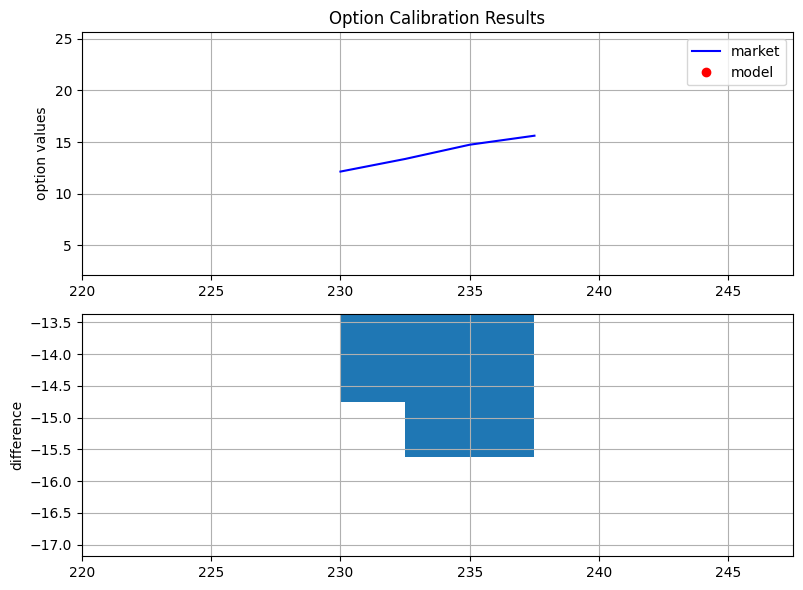

In [ ]:
plot_calibration_results(params)

Full Bates 1996 Calibration

In [ ]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s]

In [ ]:
i = 0
min_MSE = 5000.0


def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options.iterrows():
        model_value = B96_put_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            avg_s
        )
        se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

In [ ]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_S = p0
    values = []
    for row, option in options.iterrows():
        model_value = B96_put_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            avg_s
        )

        values.append(model_value)

    return np.array(values)

In [ ]:
full_params = B96_calibration_full()

   0 | [ 2.5000e+00  1.0000e-02  5.0000e-02 -7.5000e-01  1.0000e-02  0.0000e+00
 -5.0000e-01  0.0000e+00  2.3341e+02] | 196.982 | 196.982
  25 | [ 2.52837791e+00  1.00826475e-02  5.05675583e-02 -7.58513374e-01
  1.00569273e-02  1.12311385e-04 -5.05675583e-01  5.67558299e-05
  2.20682912e+02] |  30.841 |   7.067
  50 | [ 2.48497763e+00  1.00296578e-02  5.13710033e-02 -7.69020374e-01
  9.76013519e-03  1.28418999e-04 -5.07104799e-01  1.61655942e-04
  2.17865731e+02] |   7.243 |   0.022
  75 | [ 2.49436916e+00  1.01109320e-02  5.12933317e-02 -7.67924968e-01
  9.88610403e-03  1.15501297e-04 -5.07311954e-01  1.32077569e-04
  2.14899235e+02] |   0.076 |   0.022
 100 | [ 2.47115270e+00  1.00864522e-02  5.12519022e-02 -7.68462322e-01
  9.92723556e-03  1.11720158e-04 -5.09057003e-01  1.29292601e-04
  2.15040252e+02] |   0.023 |   0.015
 125 | [ 2.47185168e+00  1.00862369e-02  5.12573879e-02 -7.68689941e-01
  9.92574502e-03  1.12117065e-04 -5.08684903e-01  1.29072737e-04
  2.15069060e+02] |   0.0

In [ ]:
full_params

array([ 2.48150504e+00,  1.00857297e-02,  5.12826309e-02, -7.68560450e-01,
        9.90642060e-03,  1.14211895e-04, -5.07926030e-01,  1.34371173e-04,
        2.15153313e+02])

Market VS MODEL FULL PRICE

In [ ]:
def plot_full_calibration_results(p0):
    options["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()

    if 'Days to Maturity' in options.columns:
        plt.title("Maturity %s" % str(options["Days to Maturity"].iloc[0])[:10])
    else:
        # Provide a default title or handle the case differently
        plt.title("Option Calibration Results")


    plt.ylabel("option values")
    plt.plot(options.Strike, options.Price, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Price) - 10,
            max(options.Price) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Price.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

<ipython-input-76-8a1b8ee8b878>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Model"] = B96_calculate_model_values(p0)


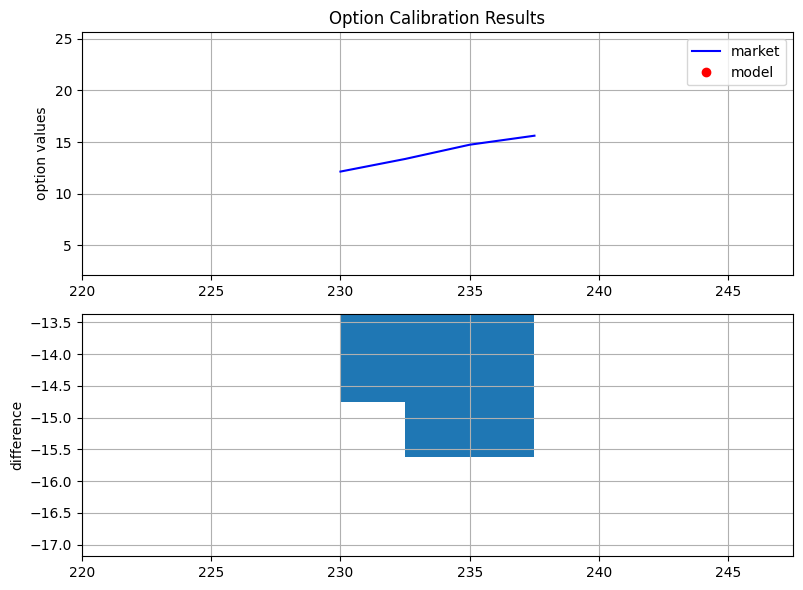

In [ ]:
plot_full_calibration_results(full_params)

Team member A

In [ ]:
import numpy as np
from scipy.integrate import quad

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0,avg_s):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0,avg_s)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

In [ ]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

In [ ]:
def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, avg_s):
    """
    Valuation of European call option in B96 Model via Lewis (2001)

    ... (original parameter definitions)

    avg_s: float
        Average price

    Returns:
    =======
    call_value: float
        Present value of European call option
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, avg_s
        ),
        0,
        np.inf,
        limit=250,
    )[0]

    put_value = max(0, np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value - avg_s)

    return put_value

In [ ]:
options

,Days to maturity,Strike,Price,Type,r,T,Model
21,60,230.0,12.15,P,0.015,0.164384,0
22,60,232.5,13.37,P,0.015,0.164384,0
23,60,235.0,14.75,P,0.015,0.164384,0
24,60,237.5,15.62,P,0.015,0.164384,0


In [ ]:
K = 230.0

In [ ]:
print(
    "B96 Call option price via Lewis(2001): $%10.4f"
    % B96_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s)
)

B96 Call option price via Lewis(2001): $    0.0000


In [ ]:
K = 232.5

In [ ]:
print(
    "B96 Call option price via Lewis(2001): $%10.4f"
    % B96_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s)
)

B96 Call option price via Lewis(2001): $    0.0000


In [ ]:
K = 235.0

In [ ]:
print(
    "B96 Call option price via Lewis(2001): $%10.4f"
    % B96_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s)
)

B96 Call option price via Lewis(2001): $    0.0000


In [ ]:
K = 237.5

In [ ]:
print(
    "B96 Call option price via Lewis(2001): $%10.4f"
    % B96_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s)
)

B96 Call option price via Lewis(2001): $    0.0000


Carr and Madan Approach

In [ ]:
def B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, avg_s):
    """
    Put option price in Bates (1996) under FFT

    ... (original parameter definitions)

    avg_s: float
        Average price

    Returns:
    =======
    put_value: float
        Present value of European put option
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        PutValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        PutValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    PutValue = PutValueM[pos] * S0

    return PutValue

In [ ]:
K = 230.0

In [ ]:
print(
    "B96 Call option price via FFT: $%10.4f"
    % B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s)
)

B96 Call option price via FFT: $    5.7612


In [ ]:
K = 232.5

In [ ]:
print(
    "B96 Call option price via FFT: $%10.4f"
    % B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s)
)

B96 Call option price via FFT: $    4.2712


In [ ]:
K = 235.0

In [ ]:
print(
    "B96 Call option price via FFT: $%10.4f"
    % B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s)
)

B96 Call option price via FFT: $    3.0402


In [ ]:
K = 237.5

In [ ]:
print(
    "B96 Call option price via FFT: $%10.4f"
    % B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta,avg_s)
)

B96 Call option price via FFT: $    2.0689


In [3]:
from google.colab import files

# Convert the notebook to HTML
!jupyter nbconvert --to html GWP_622_Step_1_and_3_.ipynb # Removed html/content/ to save the file to the current directory

# Download the generated HTML file using the correct file name
files.download('GWP_622_Step_1_and_3_.html') # Corrected filename to match nbconvert output and removed special character

[NbConvertApp] Converting notebook GWP_622_Step_1_and_3_.ipynb to html
[NbConvertApp] Writing 6191491 bytes to GWP_622_Step_1_and_3_.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
from google.colab import files

# Convert the notebook to HTML
!jupyter nbconvert --to html/content/GWP_622_Step_1_and_3_.ipynb

# Download the generated HTML file using the correct file name
files.download('/content/Step_1_&_3.html') # Changed filename to match the output of nbconvert

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

FileNotFoundError: Cannot find file: /content/Step_1_&_3.html